# Building Machine Learning Model

## Loading clean dataset

We will now load the dataset that we have processed yesterday.

In [41]:
import pandas as pd

df = pd.read_csv("dataset/clean-dataset.csv")

View the first five rows

In [42]:
df.head()

,Unnamed: 0,NO,NO2,NOX,O3,PM10,PM2.5,SO2,WIND,WINDS
0,3627,64.600000,22.600000,92.200000,8.460000,15.800000,15.000000,22.000000,47.720640,1.920000
1,3628,51.000000,28.090909,83.636364,15.381818,22.818182,27.818182,6.818182,49.164558,2.000000
2,3629,66.000000,23.909091,94.545455,10.572727,28.363636,28.636364,14.909091,50.890575,2.090909
3,3630,96.090909,26.272727,127.363636,9.200000,23.363636,16.090909,15.545455,31.543421,2.427273
4,3631,135.272727,26.090909,166.090909,10.218182,15.272727,20.363636,7.363636,45.036002,2.527273


### Problem Definition

Suppose that the particle matter filter `PM10` has begun to malfunction, and we want to use historical data (2010-2014) to estimate value from our functioning filter.

We need first to look into the relationship between `PM10` and other sensors (variables). For that we are going to visualise their relationship using scatter plots.

#### Regression plot

<Axes: xlabel='PM10', ylabel='PM2.5'>

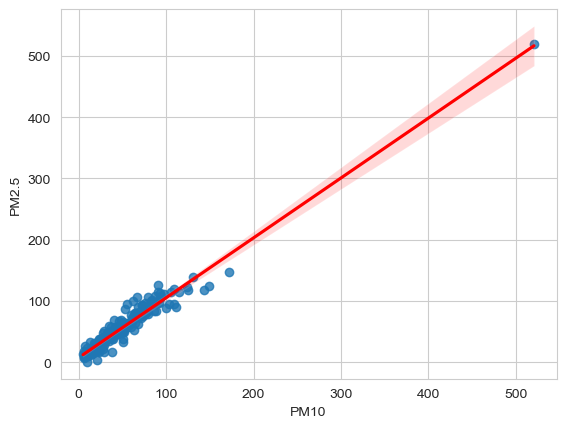

In [43]:
import seaborn as sns

sns.set_style("whitegrid")
sns.regplot(data=df, x="PM10", y="PM2.5", line_kws={"color":"red"}, ci=99)

#### Pairplot

/Users/faiz/miniconda3/envs/werk/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


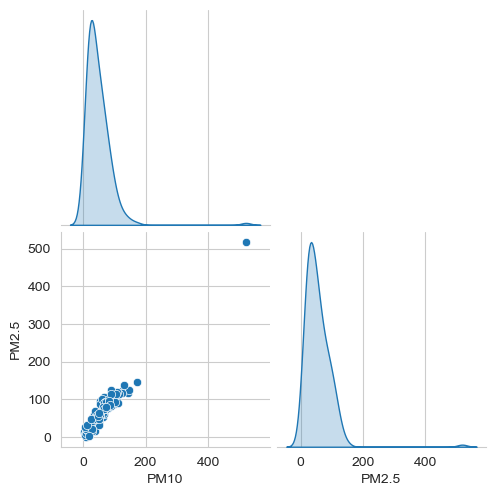

In [44]:
sns.pairplot(
    df[["PM10", "PM2.5"]],
    diag_kind="kde",
    corner=True
)

We are now going to define a variable `x`, which represents our model's input and variable `y`, which is our model's output (or in this case, the target variable).

In [45]:
x = df[["NO", "NO2", "NOX", "O3", "PM2.5", "SO2", "WIND", "WINDS"]]

In [46]:
y = df[["PM10"]]

In [47]:
x.head()

,NO,NO2,NOX,O3,PM2.5,SO2,WIND,WINDS
0,64.600000,22.600000,92.200000,8.460000,15.000000,22.000000,47.720640,1.920000
1,51.000000,28.090909,83.636364,15.381818,27.818182,6.818182,49.164558,2.000000
2,66.000000,23.909091,94.545455,10.572727,28.636364,14.909091,50.890575,2.090909
3,96.090909,26.272727,127.363636,9.200000,16.090909,15.545455,31.543421,2.427273
4,135.272727,26.090909,166.090909,10.218182,20.363636,7.363636,45.036002,2.527273


In [48]:
y.head()

,PM10
0,15.800000
1,22.818182
2,28.363636
3,23.363636
4,15.272727


## Training and Validation Sets

In ML, it is common practice to divide/organise our dataset into training and validation sets - and sometime test set. But in our case, we only have small dataset, so we will omit the test set.

For this purpose, we will use scikit-learn `train_test_split(...)` function to separate our data into these individual sets (train and validation).

*Please install `scikit-learn` module via Anaconda Navigator or Anaconda Prompt*

In [49]:
from sklearn.model_selection import train_test_split

# We split dataset into training set (X_train, y_train) and validation set (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

Let's check our training and validation sets structure

In [50]:
print("X_train #rows: %d #columns: %d" % (X_train.shape[0], X_train.shape[1]))
print("X_val #rows: %d #columns: %d" % (X_val.shape[0],X_val.shape[1]))

X_train #rows: 148 #columns: 8
X_val #rows: 64 #columns: 8


## Data Normalisation

It is evident in the dataset, variables such as `WIND` values are confined to `[0, 360]`. However other measurements do not necessarily fall within this same range. For instance `O3` rarely exceeds values of 40, whilst `NOX` can reach up to 600.

To standardise these measurements, we can adjust/scale them to fall within the range of `[0,1]`. For that we will use the following:

$$ \frac{X-min}{max-min} $$

With this transformation, an $X$ equal to the max results in an output of $1$, while an $X$ equal to the min provides an output of $0$.

In [51]:
# Get max and min from training set
X_max, X_min = X_train.max(), X_train.min()
y_max, y_min = y_train.max(), y_train.min()

### Normalisation

In [52]:
# Training set
X_train_norm = (X_train-X_min)/(X_max-X_min)
y_train_norm = (y_train-y_min)/(y_max-y_min)

# Validation set
X_val_norm = (X_val-X_min)/(X_max-X_min)
y_val_norm = (y_val-y_min)/(y_max-y_min)

Let's now check their new values

In [53]:
print(X_train_norm.max())

NO       1.0
NO2      1.0
NOX      1.0
O3       1.0
PM2.5    1.0
SO2      1.0
WIND     1.0
WINDS    1.0
dtype: float64


In [54]:
X_train_norm.min()

NO       0.0
NO2      0.0
NOX      0.0
O3       0.0
PM2.5    0.0
SO2      0.0
WIND     0.0
WINDS    0.0
dtype: float64

## Model 1: Multilayer Perceptron

We will build a very straightforward model using neural network via `sklearn.neural_network.MLPRegressor`.

With MLP, our goal is to predict a continuous numerical value (`PM10`). This is called regression.

In [55]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(32,64))

nn.fit(X_train_norm, y_train_norm.values.ravel())

MLPRegressor(hidden_layer_sizes=(32, 64))

#### Predict

In [56]:
y_pred = nn.predict(X_val_norm)

In [57]:
print("Predictions: %d" % y_pred.shape)

Predictions: 64


### Visualisation of prediction vs actual

We will use a scatter plot to visualise our model's predictions against the actual values.

Text(0.5, 1.0, 'Predictions vs Actual Values')

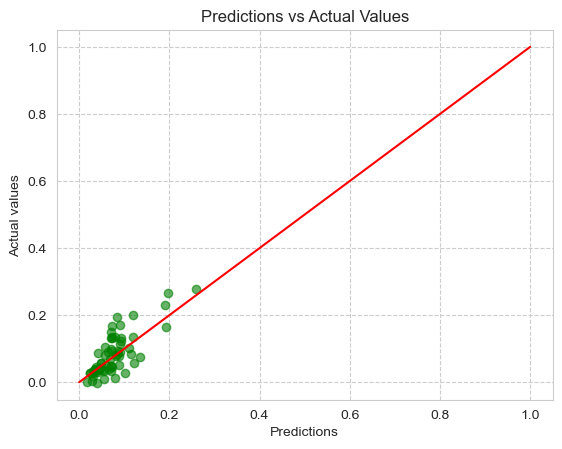

In [58]:
import matplotlib.pyplot as plt 

plt.plot([0,1], [0,1], c="red")
plt.scatter(y_pred, y_val_norm, alpha=0.6, c="green")
plt.grid(linestyle="--")

# Labels
plt.xlabel("Predictions")
plt.ylabel("Actual values")
plt.title("Predictions vs Actual Values")

### Scoring Metrics

We will use 4 performance metrics to evaluate our model:

1. `r2_score` - represents the coefficient of determination. Ideal score is 1.
2. `explained_variance_score` - represents the proportion of variation in a dataset. 1 is perfect performance.
3. `mean_squared_error` - is the average of the squares of the difference between predicted and actual values. 0 means perfect accuracy.
4. `mean_absolute_error` - similar to `mean_squared_error` but the absolute values of the differences between actual and predicted values. 0 means perfect accuracy.

In [59]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

print("R2 score: %.4f" % r2_score(y_val_norm, y_pred))
print("Explained variance score: %.4f" % explained_variance_score(y_val_norm, y_pred))
print("Mean-squared error: %.4f" % mean_squared_error(y_val_norm, y_pred))
print("Mean-absolute error: %.4f" % mean_absolute_error(y_val_norm, y_pred))


R2 score: 0.5883
Explained variance score: 0.5995
Mean-squared error: 0.0016
Mean-absolute error: 0.0297


### Tracking Modeling Experiment Results

We will define two functions: `plot_preds(...)` and `calc_metrics(...)` which we will be using multiple times later.

In [60]:
def plot_preds(y_pred, y_val):
    plt.plot([0,1], [0,1], c="red")
    plt.scatter(y_pred, y_val, alpha=0.6, c="green")
    plt.grid(linestyle="--")

    # Labels
    plt.xlabel("Predictions")
    plt.ylabel("Actual values")
    plt.title("Predictions vs Actual Values")

def calc_metrics(y_pred, y_val):
    r2 = r2_score(y_val, y_pred)
    ev = explained_variance_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    print("R2 score: %.4f" % r2)
    print("Explained variance score: %.4f" % ev)
    print("Mean-squared error: %.4f" % mse)
    print("Mean-absolute error: %.4f" % mae)

    return r2,ev,mse,mae

Store our results in a dataframe...for tracking purposes.

In [61]:
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

R2 score: 0.5883
Explained variance score: 0.5995
Mean-squared error: 0.0016
Mean-absolute error: 0.0297


In [62]:
experiments = ["BasicNN"]*4
metric_name = ["R2", "Explained Variance Score", "Mean-Squared Error", "Mean Absolute Error"]
metric_vals = [r2, ev, mse, mae]

## Model 2: Optimising Hyperparameters

We will now modify our original MLP with different parameters. We will use wider network architecture, a `batch_size` of 32 and `tanh` activation function.

In [63]:
# define network architecture
opt_nn = MLPRegressor(
    hidden_layer_sizes = (64,128,256),
    batch_size=32,
    activation="tanh",
    solver="adam"
)

#### Train model

In [64]:
opt_nn.fit(X_train_norm, y_train_norm.values.ravel())

MLPRegressor(activation='tanh', batch_size=32,
             hidden_layer_sizes=(64, 128, 256))

### Prediction

In [65]:
y_pred = opt_nn.predict(X_val_norm)

#### Plot results and calculate scores

R2 score: 0.8832
Explained variance score: 0.9400
Mean-squared error: 0.0005
Mean-absolute error: 0.0171


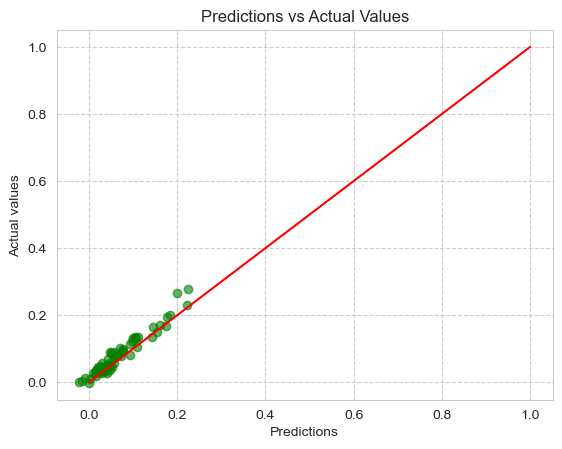

In [66]:
plot_preds(y_pred, y_val_norm)
r2,ev,mse,mae = calc_metrics(y_pred, y_val_norm)

#### Keep track of our results

In [67]:
experiments.extend(["AdvancedNN"]*4)
metric_name.extend(["R2", "Explained Variance Score", "Mean-Squared Error", "Mean Absolute Error"])
metric_vals.extend([r2, ev, mse, mae])

## Model 3: Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

# Model definition
gb = GradientBoostingRegressor(
    n_estimators=2000,
    max_depth=20,
    learning_rate=1e-3,
)

#### Train model

In [69]:
gb.fit(X_train_norm, y_train_norm.values.ravel())

GradientBoostingRegressor(learning_rate=0.001, max_depth=20, n_estimators=2000)

#### Predict

In [70]:
y_pred = gb.predict(X_val_norm)

#### Plot predictions and calculate scores

R2 score: 0.8323
Explained variance score: 0.8338
Mean-squared error: 0.0007
Mean-absolute error: 0.0171


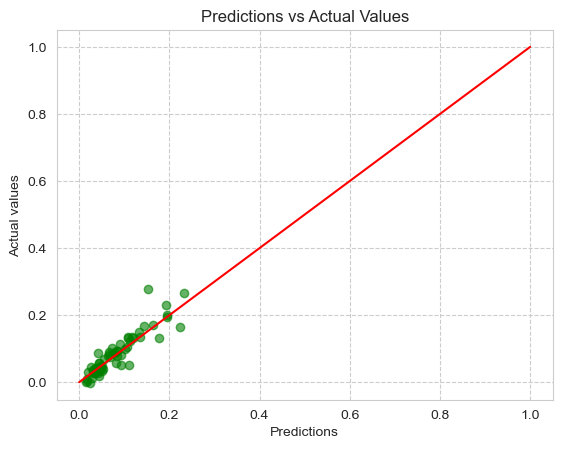

In [71]:
plot_preds(y_pred, y_val_norm)
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

#### Keeping track of our results

In [72]:
experiments.extend(["GradBoosting"]*4)
metric_name.extend(["R2", "Explained Variance Score", "Mean-Squared Error", "Mean Absolute Error"])
metric_vals.extend([r2, ev, mse, mae])

## Model 4: Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=300)

#### Train the model

In [74]:
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(n_estimators=300)

#### Predict

In [75]:
y_pred = rf.predict(X_val_norm)

#### Plot results and scores

R2 score: 0.9276
Explained variance score: 0.9300
Mean-squared error: 0.0003
Mean-absolute error: 0.0114


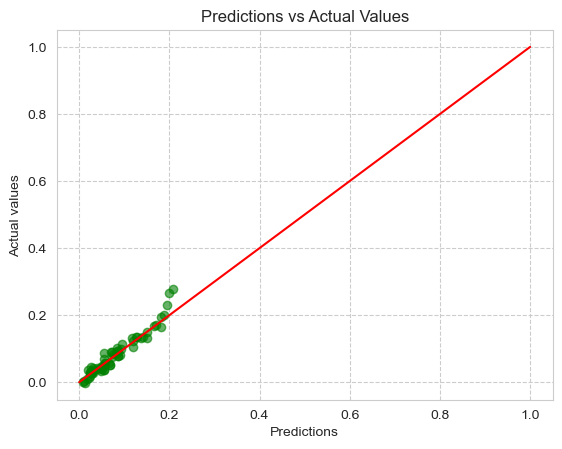

In [76]:
plot_preds(y_pred, y_val_norm)
r2, ev, mse, mae = calc_metrics(y_pred, y_val_norm)

#### Store our results

In [77]:
experiments.extend(["RandomForest"]*4)
metric_name.extend(["R2", "Explained Variance Score", "Mean-Squared Error", "Mean Absolute Error"])
metric_vals.extend([r2, ev, mse, mae])

## Comparing Models


In [78]:
df_results = pd.DataFrame()
df_results["Experiments"] = experiments
df_results["Metric"] = metric_name
df_results["Value"] = metric_vals

In [79]:
df_results

,Experiments,Metric,Value
0,BasicNN,R2,0.588270
1,BasicNN,Explained Variance Score,0.599492
2,BasicNN,Mean-Squared Error,0.001607
3,BasicNN,Mean Absolute Error,0.029703
4,AdvancedNN,R2,0.883213
5,AdvancedNN,Explained Variance Score,0.939953
6,AdvancedNN,Mean-Squared Error,0.000456
7,AdvancedNN,Mean Absolute Error,0.017147
8,GradBoosting,R2,0.832320
9,GradBoosting,Explained Variance Score,0.833754


### Visualisation of model comparison

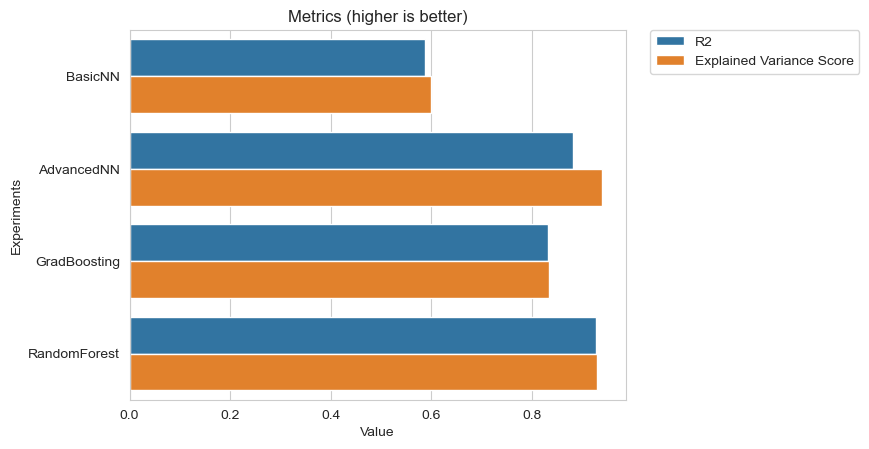

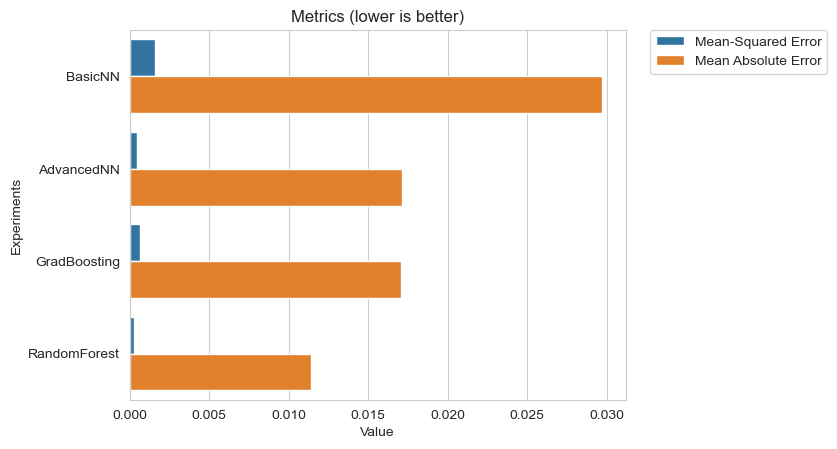

In [80]:
plt.figure()
sns.barplot(
    data=df_results[df_results.Metric.isin(["R2", "Explained Variance Score"])],
    orient="h", #horizontal
    x="Value",
    y="Experiments",
    hue="Metric"
).set(title="Metrics (higher is better)")

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0)

plt.figure()
sns.barplot(
    data=df_results[df_results.Metric.isin(["Mean-Squared Error", "Mean Absolute Error"])],
    orient="h", #horizontal
    x="Value",
    y="Experiments",
    hue="Metric"
).set(title="Metrics (lower is better)")

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0)